# Riemannian Robust M-estimator(FULDA Hyperbolic Data : corrupted)

Lead author: Jihyun Ryu

This notebook shows how to compute location parameter from the data based on the concept of M-estimators. 
By taking advantage of the robustness property of several M-estimators in the Euclidean space, we will see that location parameter from the samples on a certain Riemannian manifold is properly computed in the case when data contaminated with a small amount of outliers on the same Riemannian manifold.

We utilize the package "Geomstats" for optimization on the Riemannian manifolds. By taking advantage of Geomstats, we can easily get metrics, distances, geodesics of well-known manifolds. Additionally, we provide a new computation tool for estimating the location parameter of several M-estimators or customized M-estimator cost functions based on Geomstats. To fully use this computation tool, we recommend to install package Geomstats(numpy backend), and Geomstats with autograd backend by scripts below.

In [ ]:
pip install geomstats
pip install geomstats[autograd]

After installing this package, we can start this example by code below.
(gs.has_autodiff() is True if GEOMSTATS_BACKEND = "autograd" or "pytorch" otherwise False, meaning that we can automatically compute the gradient of both provided and properly customized loss functions, deriving optimized estimates.

In [1]:
import os
os.environ["GEOMSTATS_BACKEND"] = "autograd"
import geomstats.backend as gs
gs.has_autodiff()

True

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import geomstats.visualization as visualization
from geomstats.geometry.hyperbolic import Hyperbolic
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.poincare_half_space import PoincareHalfSpace
from geomstats.geometry.poincare_ball  import PoincareBall
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

In [3]:
import riemannian_robust_m_estimator as rrm
# from riemannian_robust_m_estimator import RiemannianRobustMean
# import importlib
# importlib.reload(rrm)
from geomstats.learning.frechet_mean import FrechetMean

In [4]:
def transform_2d_poincare_half_plane_to_poincare_disk(x):
    if len(x.shape)>1:
        x_pd = (x[:,0]+x[:,1]*1j-1j)/(x[:,0]+x[:,1]*1j+1j)
        x_pd = np.array((x_pd.real,x_pd.imag)).T
    else:
        x_pd = (x[0]+x[1]*1j-1j)/(x[0]+x[1]*1j+1j)
        x_pd = np.array([x_pd.real,x_pd.imag])    
    #isinstance(fm_pd,complex)
    return x_pd

def transform_2d_poincare_half_plane_to_hyperboloid(x):
    if len(x.shape)>1:
        hbo_x = (1+x[:,0]**2+x[:,1]**2)/(2*x[:,1])
        hbo_y = (x[:,0])/(x[:,1])
        hbo_z = (1-x[:,0]**2-x[:,1]**2)/(2*x[:,1])
        x_hbo = np.array((hbo_x,hbo_y,hbo_z)).T
    else:
        hbo_x = (1+x[0]**2+x[1]**2)/(2*x[1])
        hbo_y = (x[0])/(x[1])
        hbo_z = (1-x[0]**2-x[1]**2)/(2*x[1])
        x_hbo = np.array([hbo_x,hbo_y,hbo_z])
    return x_hbo

def transform_2d_poincare_disk_to_poincare_half_plane(x):
    if len(x.shape)>1:
        x_phs = ((1+x[:,0]+x[:,1]*1j)/(1-x[:,0]+x[:,1]*1j))*1j
        x_phs = np.array((x_phs.real,x_phs.imag)).T
    else:
        x_phs = ((1+x[0]+x[1]*1j)/(1-x[0]+x[1]*1j))*1j
        x_phs = np.array([x_phs.real,x_phs.imag])    
    #isinstance(fm_pd,complex)
    return x_pd

## Load FULDA corrupted data

In [5]:
import pandas as pd
#data = pd.read_clipboard(header=None)
data = pd.read_csv('data/FULDA_corrupted.csv',header=None)
data.columns = ['L','R']
print(len(data))

92


In [6]:
data.head()

,L,R
0,2.48,-1.85
1,2.50,-1.87
2,2.65,-1.79
3,2.63,-1.80
4,2.62,-1.80


In [7]:
points = data.to_numpy()
rotation_90 = np.array([[0,-1],[1,0]])
points_90r = np.array([rotation_90@i for i in points])

In [8]:
pb = PoincareBall(2)
print('On Poincare Ball manifold?',pb.belongs(points).all())
print('After 90 degree rotation On Poincare Ball manifold?',pb.belongs(points_90r).all())

On Poincare Ball manifold? False
After 90 degree rotation On Poincare Ball manifold? False


In [9]:
phs = PoincareHalfSpace(2)
print('On Poincare half space manifold?',phs.belongs(points).all())
print('After 90 degree rotation On Poincare half space manifold?',phs.belongs(points_90r).all())

On Poincare half space manifold? False
After 90 degree rotation On Poincare half space manifold? True


In [10]:
hbo = Hyperboloid(2)
print('On Poincare half space manifold?',hbo.belongs(points).all())
print('After 90 degree rotation On Poincare half space manifold?',hbo.belongs(points_90r).all())

On Poincare half space manifold? False
After 90 degree rotation On Poincare half space manifold? False


## Visualizing data with Poincare Half plane, Poincare disk , Hyperboloid

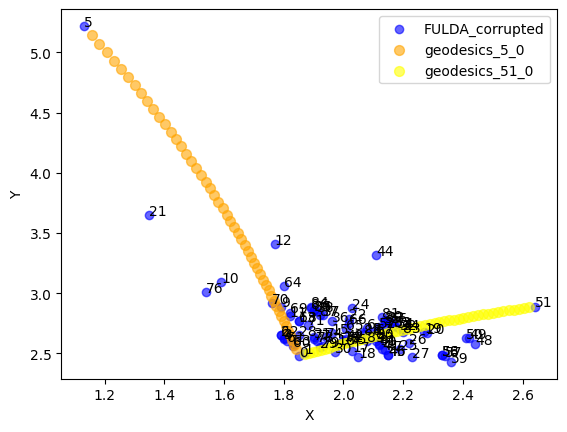

In [11]:
visualization.plot(points_90r,space='H2_poincare_half_plane', c='blue', alpha=0.6, label='FULDA_corrupted')
for i in range(len(points_90r)):
    plt.text(points_90r[i,0],points_90r[i,1],i)

geodesics = phs.metric.geodesic(points_90r[5],points_90r[0])
visualization.plot(geodesics(np.linspace(0.02,0.97,50)),
                   space='H2_poincare_half_plane', c='orange', s=50, alpha=0.6, label='geodesics_5_0')
geodesics = phs.metric.geodesic(points_90r[51],points_90r[0])
visualization.plot(geodesics(np.linspace(0.02,0.97,50)),
                   space='H2_poincare_half_plane', c='yellow', s=50, alpha=0.6, label='geodesics_51_0')
plt.legend()

BELONGS Poincare Disk? True


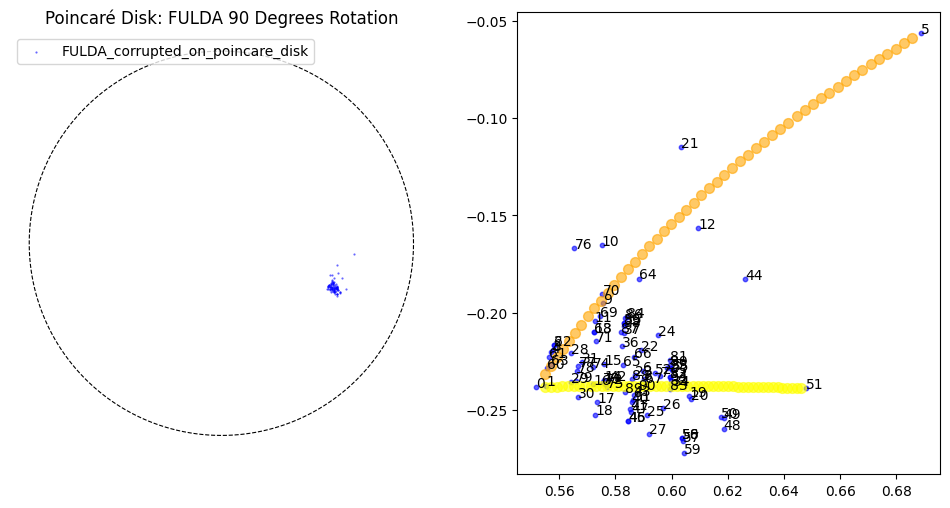

In [42]:
points_to_disk_n = transform_2d_poincare_half_plane_to_poincare_disk(points_90r)
print('BELONGS Poincare Disk?',pb.belongs(points_to_disk_n).all())

fig, ax = plt.subplots(1,2,figsize=(12,6))
theta = np.linspace(0,2*np.pi,200)
ax[0].plot(np.cos(theta), np.sin(theta), 'k--', lw=0.8)
ax[0].scatter(points_to_disk_n[:,0], points_to_disk_n[:,1], c='blue', alpha=0.6, s=0.3, label='FULDA_corrupted_on_poincare_disk')
ax[0].set_xlim([-1.1, 1.1])
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_aspect('equal')
ax[0].axis('off')
ax[0].legend(loc='upper left')
ax[0].set_title("Poincaré Disk: FULDA 90 Degrees Rotation")
ax[1].scatter(points_to_disk_n[:,0], points_to_disk_n[:,1], c='blue', alpha=0.6, s=10, label='Zooomed')

for i in range(len(points_to_disk_n)):
    ax[1].text(points_to_disk_n[i,0],points_to_disk_n[i,1],i)
    

geodesics = pb.metric.geodesic(points_to_disk_n[5],points_to_disk_n[0])
ax[1].scatter(geodesics(np.linspace(0.02,0.97,50))[:,0],geodesics(np.linspace(0.02,0.97,50))[:,1],
              c='orange', s=50, alpha=0.6, label='geodesics_5_0')
geodesics = pb.metric.geodesic(points_to_disk_n[51],points_to_disk_n[0])
ax[1].scatter(geodesics(np.linspace(0.02,0.97,50))[:,0],geodesics(np.linspace(0.02,0.97,50))[:,1],
              c='yellow', s=50, alpha=0.6, label='geodesics_51_0')

In [135]:
def squaredist(space,points,base,critical_value,weights=None,loss_and_grad=True):
    n = len(points)
    logs = space.metric.log(points,base)
    dists = space.metric.dist(points,base)

    loss = gs.sum(dists**2)/n
    if not loss_and_grad:
        return loss
    grad = -2*gs.sum(logs,axis=0)/n
    return loss, space.to_tangent(grad,base)

def get_random_color_rgb(n=1):
    if n==1:
        return '#'+''.join(np.random.choice(list('0123456789abcdef'),6,replace=True))
    return ['#'+''.join(np.random.choice(list('0123456789abcdef'),6,replace=True)) for i in range(n)]

import matplotlib.cm as cm
cmap = cm.get_cmap('Set2')  


pb = PoincareBall(2)

mest_meta = {
    'huber'   : (np.array([0.01,0.1,0.5,0.75,1,1.345,2,3])/10,-3,cmap.colors[0][:3]),
    'cauchy'  : (np.array([0.01,0.1,1,1.5,2,2.385,2.5,3,5])/10,-4,cmap.colors[1][:3]),
    'biweight': (np.array([0.5,1,2,3,4,4.6851,5,6,7])/10,-4,cmap.colors[2][:3]),
    'fair'    : (np.array([0.01,0.1,0.5,1,1.3998,1.5,2,3])/10,-4,cmap.colors[3][:3]),
    'hampel'  : (np.array([0.01,0.1,0.5,1,1.35,1.5,2,3])/10,-4,cmap.colors[4][:3]),
    'welsch'  : (np.array([0.05,0.5,1,2,2.9846,4,5,6])/10,-4,cmap.colors[5][:3])
}
m_ests = {}
for m_est,(cutoffs,_,__) in mest_meta.items():
    m_ests[m_est] = {}
    for c in cutoffs:
        m_ests[m_est][c] = rrm.RiemannianRobustMestimator(
            space=pb,
            critical_value=c,
            m_estimator=m_est,
            init_point_method='mean-projection',
            method='adaptive'
        )
        m_ests[m_est][c].set(init_step_size=0.5,epsilon=1e-7,max_iter=8192) #,init_point=points_to_disk_n[75])
        m_ests[m_est][c].fit(points_to_disk_n)

fm = rrm.RiemannianRobustMestimator(
    space=pb,
    critical_value=1,
    m_estimator='custom',
    init_point_method='mean-projection',
    method='default'
)
fm.set_loss(squaredist)
fm.set(init_step_size=0.5,epsilon=1e-7,max_iter=8192) #,init_point=points_to_disk_n[75])
fm.fit(points_to_disk_n)


C:\Users\User\AppData\Local\Temp\ipykernel_39012\3536326934.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2')


RiemannianRobustMestimator(critical_value=1,
                           init_point_method='mean-projection',
                           m_estimator='custom',
                           space=<geomstats.geometry.poincare_ball.PoincareBall object at 0x0000020930A2BE20>)

(array([[ 5., 19., 20., ...,  0.,  1.,  0.],
        [ 7., 19., 24., ...,  0.,  1.,  0.],
        [ 8., 20., 25., ...,  0.,  0.,  0.],
        ...,
        [19., 33., 24., ...,  1.,  0.,  0.],
        [19., 33., 26., ...,  1.,  0.,  0.],
        [15., 33., 25., ...,  0.,  1.,  0.]]),
 array([0.        , 0.04159592, 0.08319184, 0.12478776, 0.16638368,
        0.2079796 , 0.24957551, 0.29117143, 0.33276735, 0.37436327,
        0.41595919, 0.45755511, 0.49915103, 0.54074695, 0.58234287,
        0.62393879, 0.6655347 , 0.70713062, 0.74872654, 0.79032246,
        0.83191838]),
 <a list of 92 BarContainer objects>)

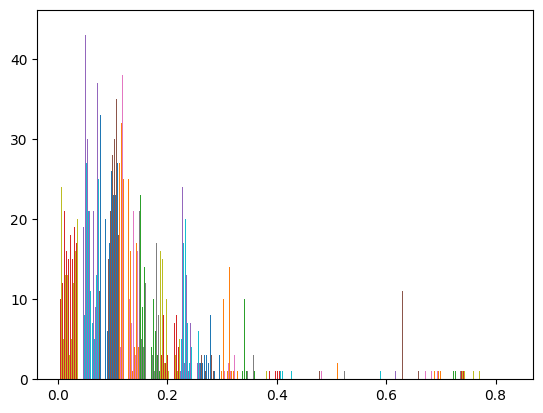

In [19]:
plt.hist(pb.metric.dist_pairwise(points_to_disk_n),bins=20)

BELONGS Poincare Disk? True


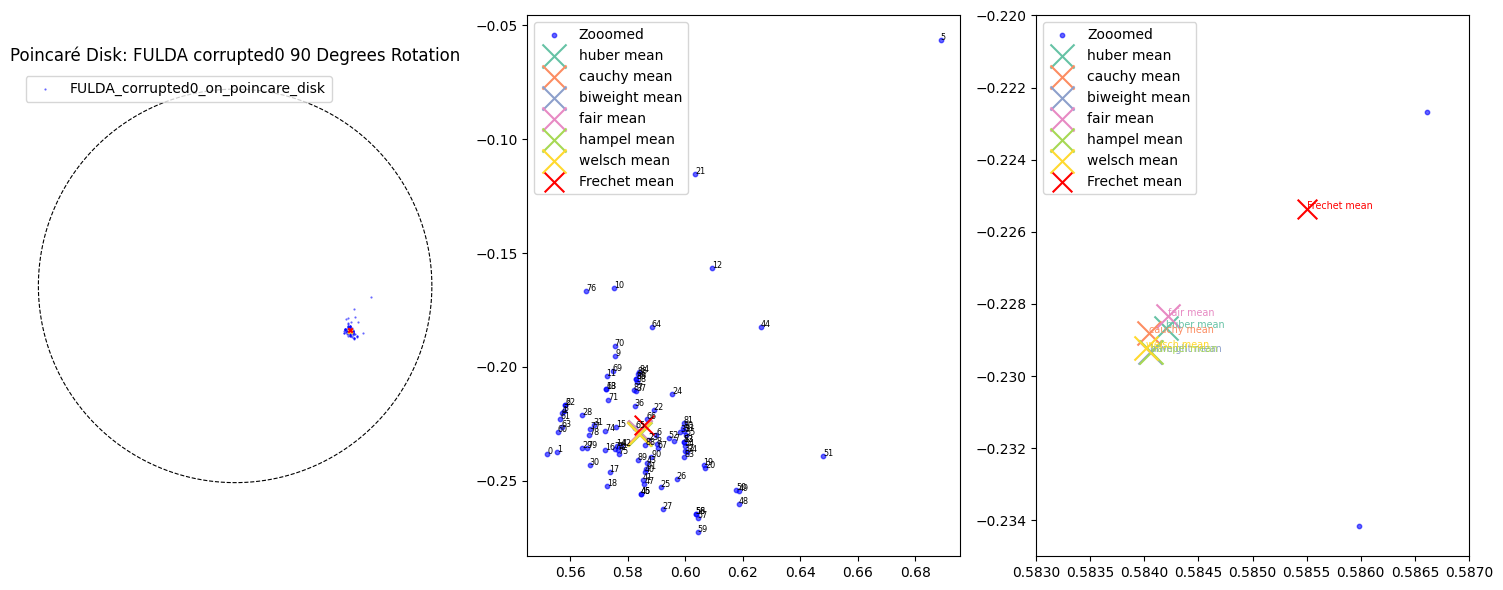

In [136]:
points_to_disk_n = transform_2d_poincare_half_plane_to_poincare_disk(points_90r)
print('BELONGS Poincare Disk?',pb.belongs(points_to_disk_n).all())

fig, ax = plt.subplots(1,3,figsize=(15,6))
theta = np.linspace(0,2*np.pi,200)
ax[0].plot(np.cos(theta), np.sin(theta), 'k--', lw=0.8)
ax[0].scatter(points_to_disk_n[:,0], points_to_disk_n[:,1], c='blue', alpha=0.6, s=0.3, label='FULDA_corrupted0_on_poincare_disk')
ax[0].set_xlim([-1.1, 1.1])
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_aspect('equal')
ax[0].axis('off')
ax[0].legend(loc='upper left')
ax[0].set_title("Poincaré Disk: FULDA corrupted0 90 Degrees Rotation")
ax[1].scatter(points_to_disk_n[:,0], points_to_disk_n[:,1], c='blue', alpha=0.6, s=10, label='Zooomed')
ax[2].scatter(points_to_disk_n[:,0], points_to_disk_n[:,1], c='blue', alpha=0.6, s=10, label='Zooomed')

for i in range(len(points_to_disk_n)):
    ax[1].text(points_to_disk_n[i,0],points_to_disk_n[i,1],i, fontsize='xx-small')

for m_est,(cutoffs,ix,col) in mest_meta.items():
    c = cutoffs[ix]
    ax[0].scatter(*m_ests[m_est][c].estimate_.x,s=10,alpha=1,color=col,marker='x',label=f'{m_est} mean')
    ax[1].scatter(*m_ests[m_est][c].estimate_.x,s=300,alpha=1,color=col,marker='x',label=f'{m_est} mean')
    ax[2].scatter(*m_ests[m_est][c].estimate_.x,s=300,alpha=1,color=col,marker='x',label=f'{m_est} mean')
    ax[2].text(*m_ests[m_est][c].estimate_.x,color=col,fontsize='x-small',s=f'{m_est} mean')
ax[0].scatter(*fm.estimate_.x,s=10,alpha=1,marker='x',c='red',label='Frechet mean')
ax[1].scatter(*fm.estimate_.x,s=200,alpha=1,marker='x',c='red',label='Frechet mean')
ax[2].scatter(*fm.estimate_.x,s=200,alpha=1,marker='x',c='red',label='Frechet mean')
ax[2].text(*fm.estimate_.x,color='red',fontsize='x-small',s=f'Frechet mean')

ax[2].set_xlim(0.583,0.587)
ax[2].set_ylim(-0.235,-0.22)

ax[1].legend()
ax[2].legend()

plt.tight_layout()

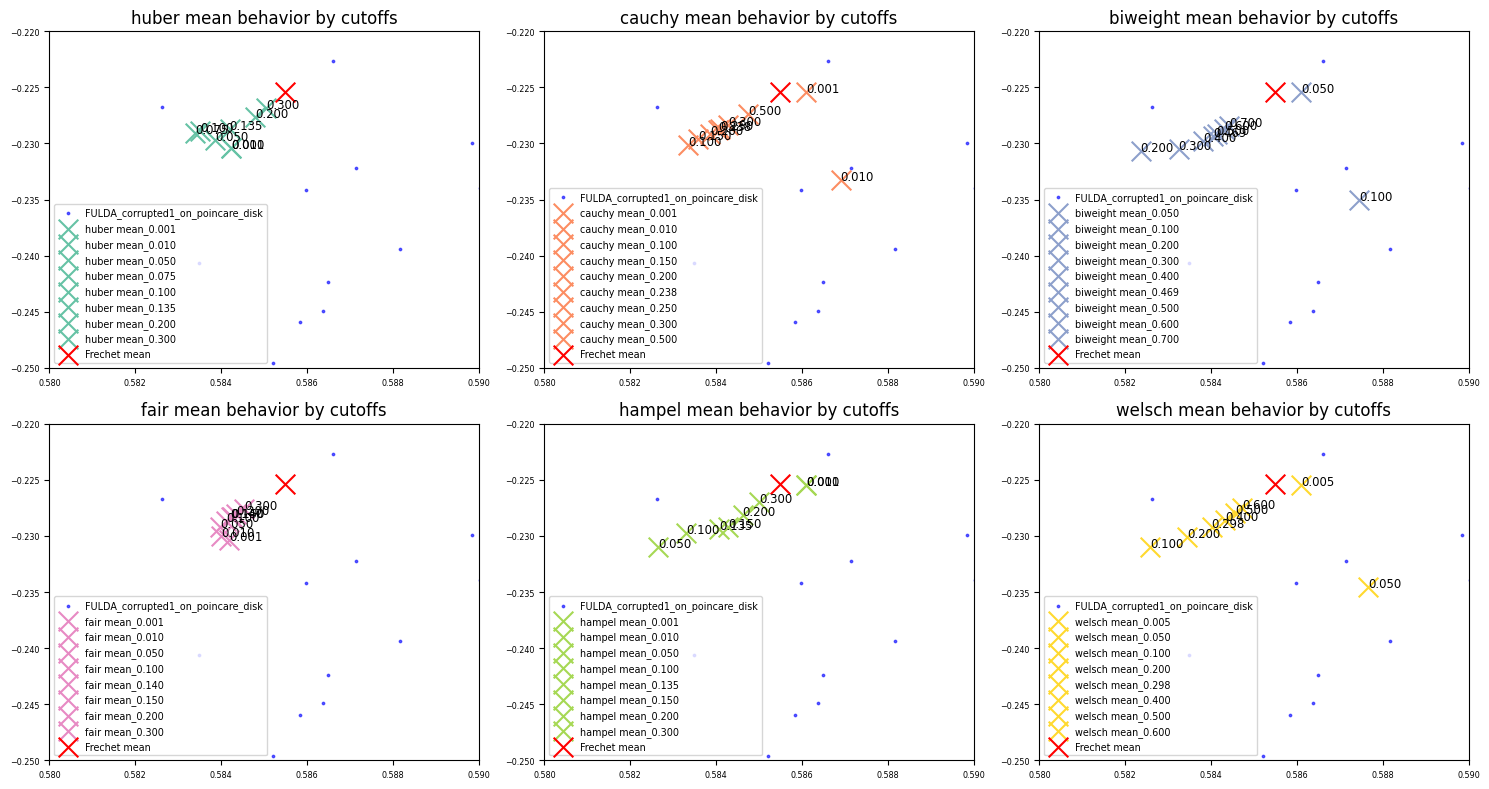

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (required for 3D)

fig = plt.figure(figsize=(15,8))
for i,(m_est,(cutoffs,ix,col)) in enumerate(mest_meta.items()):
    
    ax = fig.add_subplot(int(f'23{i+1}')) #, projection='3d')
    ax.scatter(points_to_disk_n[:,0], points_to_disk_n[:,1], c='blue', alpha=0.6, s=3, label='FULDA_corrupted1_on_poincare_disk')
    
    for c in cutoffs:
        # if (m_est=='hampel') & (c==0.10):continue
        ax.scatter(*m_ests[m_est][c].estimate_.x,s=200,alpha=1,#(c**(1/2)/(np.max(cutoffs)**(1/2)))
                   marker='x',label=f'{m_est} mean_{c:.3f}',color=col)
        ax.text(*m_ests[m_est][c].estimate_.x,s=f'{c:.3f}',fontsize='small')
    ax.scatter(*fm.estimate_.x,s=200,alpha=1,marker='x',c='red',label='Frechet mean')
    
    
    # ax.set_axis_off()  # 축 제거(선택)
    ax.legend(fontsize='x-small')
    ax.tick_params(axis='both', which='major', labelsize='xx-small')
    ax.set_xlim(0.58,0.59)
    ax.set_ylim(-0.25,-0.22)
    ax.set_title(f'{m_est} mean behavior by cutoffs')
    
# ax.set_box_aspect([1,1,1])
# ax.view_init(elev=30, azim=220) 
plt.tight_layout()
plt.show()

In [ ]:
import logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger('root').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

In [166]:
# points_to_disk_n__ = points_to_disk_n.copy()
points_to_disk_n = points_to_disk_n__.copy()

In [146]:
points_to_disk_n[5]

array([ 0.68872997, -0.05654906])

In [139]:
np.array([-1,1])*np.array([0.5,0.5])

array([-0.5,  0.5])

In [167]:

mest_meta = {
        'huber'   : (np.array([0.01,0.1,0.5,0.75,1,1.345,2,3])/10,-3,cmap.colors[0][:3]),
        'cauchy'  : (np.array([0.01,0.1,1,1.5,2,2.385,2.5,3,5])/10,-4,cmap.colors[1][:3]),
        'biweight': (np.array([0.5,1,2,3,4,4.6851,5,6,7])/10,-4,cmap.colors[2][:3]),
        'fair'    : (np.array([0.01,0.1,0.5,1,1.3998,1.5,2,3])/10,-4,cmap.colors[3][:3]),
        'hampel'  : (np.array([0.01,0.1,0.5,1,1.35,1.5,2,3])/10,-4,cmap.colors[4][:3]),
        'welsch'  : (np.array([0.05,0.5,1,2,2.9846,4,5,6])/10,-4,cmap.colors[5][:3])
    }
pb = PoincareBall(2)

point5_step = []
m_est_o = {
        'huber'   : [],
        'cauchy'  : [],
        'biweight': [],
        'fair'    : [],
        'hampel'  : [],
        'welsch'  : [],
        'fm'      : []
    }
p = points_to_disk_n[5].copy()
for k in range(50):
    points_to_disk_n[5] = p-np.array([-0.005,-0.005])*k
    point5_step.append(points_to_disk_n[5].copy())
    for m_est,(cutoffs,ix,__) in mest_meta.items():
        # for c in cutoffs:
        c = cutoffs[ix]  # if m_est!='biweight' else 0.5
        # print(m_est,c)
        m_est_o1 = rrm.RiemannianRobustMestimator(
            space=pb,
            critical_value=c,
            m_estimator=m_est,
            init_point_method='mean-projection',
            method='default'
        )
        m_est_o1.set(init_step_size=0.5 if m_est not in ['biweight','hampel'] else 5,epsilon=1e-7,max_iter=8192) #,init_point=points_to_disk_n[75])
        m_est_o1.fit(points_to_disk_n)
        m_est_o[m_est].append(m_est_o1.estimate_.x)
    
    fm = rrm.RiemannianRobustMestimator(
        space=pb,
        critical_value=1,
        m_estimator='custom',
        init_point_method='mean-projection',
        method='default'
    )
    fm.set_loss(squaredist)
    fm.set(init_step_size=0.5,epsilon=1e-7,max_iter=8192) #,init_point=points_to_disk_n[75])
    fm.fit(points_to_disk_n)
    m_est_o['fm'].append(fm.estimate_.x)

for m_est in mest_meta.keys():
    m_est_o[m_est] = np.array(m_est_o[m_est])

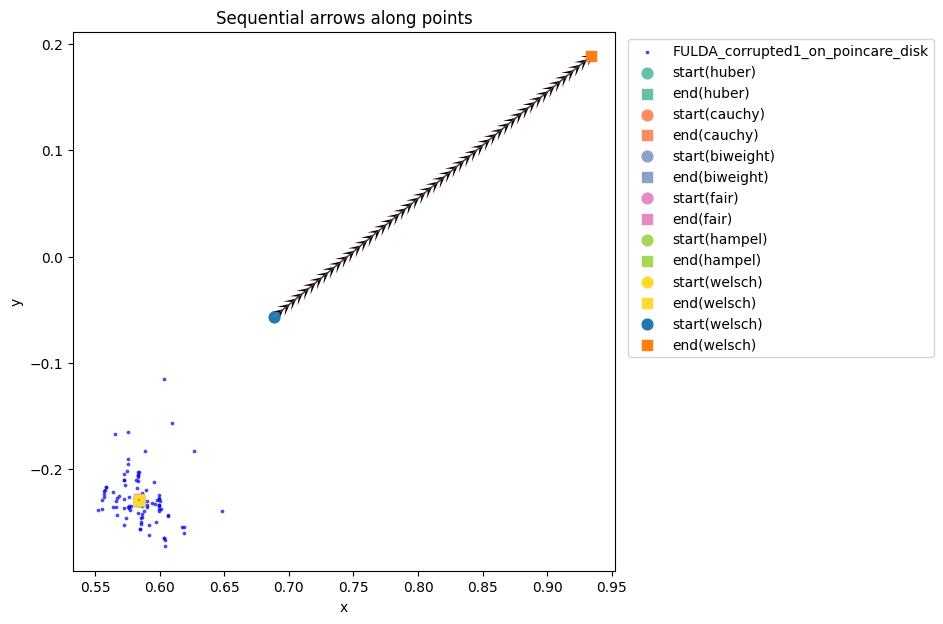

In [168]:
def plot_arrows_chain(x, y, step=1, show_points=True, ax=None, c=None, label=None):
    """
    x, y: 길이 N의 1D 배열 (예: 100 포인트)
    step: 1이면 모든 간선을 화살표로 표시, 2면 (0->2->4...) 등 간격을 키움
    show_points: 원 포인트도 찍을지 여부
    """
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    assert x.shape == y.shape and x.ndim == 1 and len(x) >= 2

    # 구간 간격 적용
    idx = np.arange(0, len(x)-1, step)
    x0, y0 = x[idx], y[idx]
    dx, dy = x[idx+1] - x[idx], y[idx+1] - y[idx]

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    # 화살표들
    ax.quiver(
        x0, y0, dx, dy,
        angles='xy', scale_units='xy', scale=0.7,
        width=0.003, headwidth=9, headlength=9
    )

    # 경로를 얇은 선으로 같이 보고 싶다면:
    ax.plot(x, y, lw=0.8, alpha=0.5)

    # 시작/끝 표시
    
    ax.scatter([x[0]], [y[0]], s=60, marker='o', color=c,
               label=f'start({label})' if label is not None else 'start')
    ax.scatter([x[-1]], [y[-1]], s=60, marker='s', color=c,
               label=f'end({label})' if label is not None else 'end')

    if show_points:
        ax.scatter(x, y, s=12)

    # ax.set_aspect('equal')
    ax.legend(loc='best')
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_title('Sequential arrows along points')
    # plt.tight_layout()
    # plt.show()

fig,ax= plt.subplots(1,1,figsize=(7,7))
ax.scatter(points_to_disk_n__[:,0], points_to_disk_n__[:,1], c='blue', alpha=0.6, s=3, label='FULDA_corrupted1_on_poincare_disk')
for m_est in mest_meta.keys():
    x,y = m_est_o[m_est][:,0],m_est_o[m_est][:,1]
    plot_arrows_chain(x, y, step=1, show_points=False, ax=ax, c=mest_meta[m_est][2], label=m_est)
plot_arrows_chain(np.array(point5_step)[:,0], np.array(point5_step)[:,1], step=1, show_points=False, ax=ax, label=m_est)
ax.legend(loc='upper left', bbox_to_anchor=(1.01,1))# 


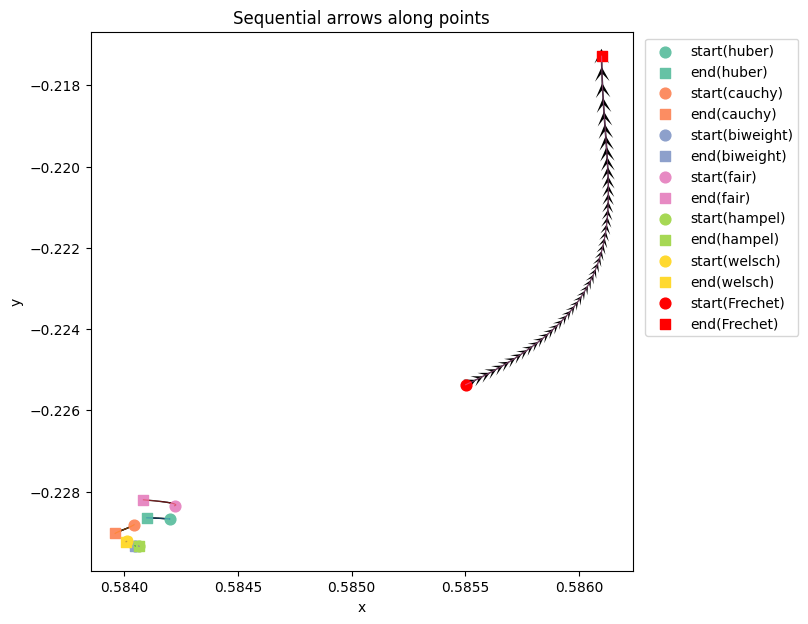

In [170]:
fig,ax= plt.subplots(1,1,figsize=(7,7))
# ax.scatter(points_to_disk_n__[:,0], points_to_disk_n__[:,1], c='blue', alpha=0.6, s=3, label='FULDA_corrupted1_on_poincare_disk')
for m_est in mest_meta.keys():
    x,y = m_est_o[m_est][:,0],m_est_o[m_est][:,1]
    plot_arrows_chain(x, y, step=1, show_points=False, ax=ax, c=mest_meta[m_est][2], label=m_est)
x,y = np.array(m_est_o['fm'])[:,0],np.array(m_est_o['fm'])[:,1]
plot_arrows_chain(x, y, step=1, show_points=False, ax=ax, c='red', label='Frechet')
# plot_arrows_chain(np.array(point5_step)[:,0], np.array(point5_step)[:,1], step=1, show_points=False, ax=ax, label=m_est)
ax.legend(loc='upper left', bbox_to_anchor=(1.01,1))# 

In [13]:
points_to_hbo = transform_2d_poincare_half_plane_to_hyperboloid(points_90r)
print('BELONGS Hyperboloid Manifold?',hbo.belongs(points_to_hbo).all())
points_to_hbo.min(axis=0),points_to_hbo.max(axis=0)

BELONGS Hyperboloid Manifold? True


(array([ 2.06538044,  0.2164751 , -2.63652299]),
 array([ 2.82809387,  0.97119342, -1.72840726]))

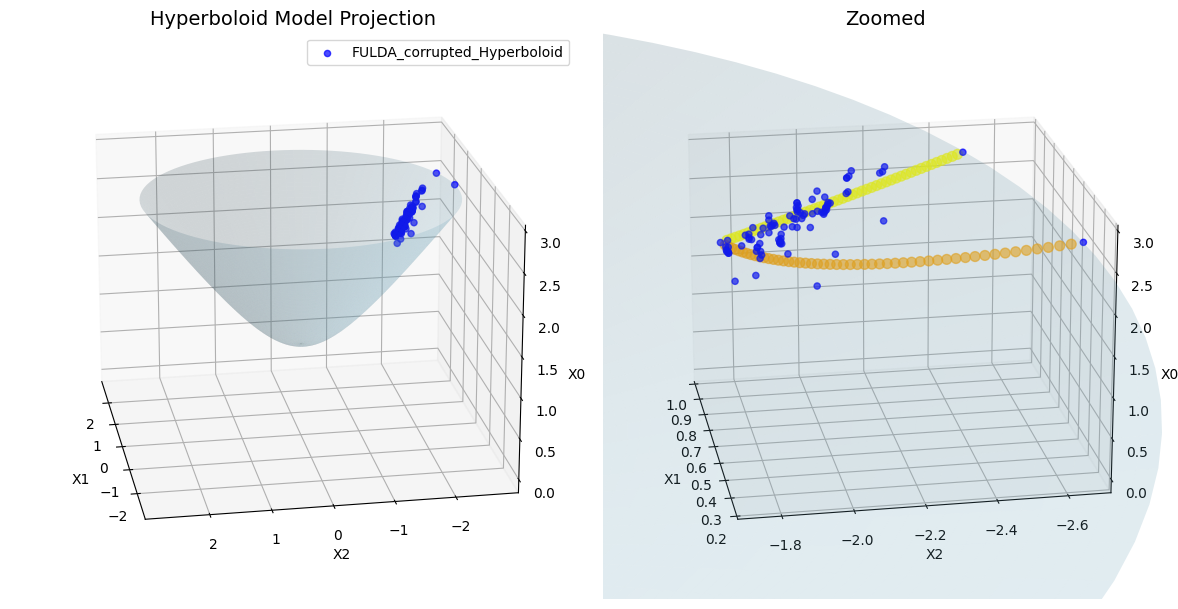

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(points_to_hbo[:, 1],  # X1
           points_to_hbo[:, 2],  # X2
           points_to_hbo[:, 0],  # X0
           color='blue', label='FULDA_corrupted_Hyperboloid', alpha=0.7)

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X0")
ax.set_zlim((-0.1,3))
ax.set_title("Hyperboloid Model Projection", fontsize=14)
ax.legend()

# Plot the hyperboloid surface with projected data
# Hyperboloid surface mesh
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, 1.7, 100)  # avoid v=1 exactly to stay on upper sheet

U, V = np.meshgrid(u, v)
X1 = np.sinh(V) * np.cos(U)
X2 = np.sinh(V) * np.sin(U)
X0 = np.cosh(V)

# Surface
ax.plot_surface(
    X1, X2, X0,
    rstride=1, cstride=1,
    color='skyblue', alpha=0.2,
    edgecolor='none'
)
plt.tight_layout()
ax.view_init(elev=20, azim=170)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points_to_hbo[:, 1],  # X1
           points_to_hbo[:, 2],  # X2
           points_to_hbo[:, 0],  # X0
           color='blue', label='FULDA_corrupted_Hyperboloid', alpha=0.7)

ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
ax2.set_zlabel("X0")
ax2.set_ylim((-2.7,-1.7))
ax2.set_xlim((0.2,1))
ax2.set_zlim((-0.1,3))
ax2.set_title("Zoomed", fontsize=14)

ax2.plot_surface(
    X1, X2, X0,
    rstride=1, cstride=1,
    color='skyblue', alpha=0.2,
    edgecolor='none'
)
ax2.view_init(elev=20, azim=170)

geodesics = hbo.metric.geodesic(points_to_hbo[5],points_to_hbo[0])
ax2.scatter(geodesics(np.linspace(0.02,0.97,50))[:,1],geodesics(np.linspace(0.02,0.97,50))[:,2],geodesics(np.linspace(0.02,0.97,50))[:,0],
              c='orange', s=50, alpha=0.6, label='geodesics_5_0')
geodesics = hbo.metric.geodesic(points_to_hbo[51],points_to_hbo[0])
ax2.scatter(geodesics(np.linspace(0.02,0.97,50))[:,1],geodesics(np.linspace(0.02,0.97,50))[:,2],geodesics(np.linspace(0.02,0.97,50))[:,0],
              c='yellow', s=50, alpha=0.6, label='geodesics_51_0')

#### Below, we can see the distances between points are the same regardless of the manifold they are on as long as the points are correctly transformed.
#### The distances are based on commonly used metrics on the manifolds respectively.

In [15]:
print('DISTANCE ON Poincare Half Plane',phs.metric.dist(points_90r[0],points_90r[51]))
print('DISTANCE ON Poincare Disk',pb.metric.dist(points_to_disk_n[0],points_to_disk_n[51]))
print('DISTANCE ON Hyperboloid',hbo.metric.dist(points_to_hbo[0],points_to_hbo[51]))
print()
print('DISTANCE ON Poincare Half Plane',phs.metric.dist(points_90r[0],points_90r[5]))
print('DISTANCE ON Poincare Disk',pb.metric.dist(points_to_disk_n[0],points_to_disk_n[5]))
print('DISTANCE ON Hyperboloid',hbo.metric.dist(points_to_hbo[0],points_to_hbo[5]))

DISTANCE ON Poincare Half Plane 0.33095007869176457
DISTANCE ON Poincare Disk 0.33095007869176457
DISTANCE ON Hyperboloid 0.3309500786917651

DISTANCE ON Poincare Half Plane 0.7683474832977576
DISTANCE ON Poincare Disk 0.7683474832977576
DISTANCE ON Hyperboloid 0.7683474832977584


#### It seems that several points are not from the same distribution. However, we cannot conclude that the points are outlier without more information from domain engineers or experts. That's why we need estimators robust to incident but inevitable outliers. 
#### Thus, by using the methodology of robust M-estimator on riemannian manifolds, we can get robust estimator of the location parameter of unknown distribution.

## Compute location parameter of M-estimator

## 0. Baseline : Frechet Mean

In [16]:
fm = FrechetMean(phs)
fm.set(max_iter=1024)
fm.fit(points_90r)
print('Frechet Mean on Poincare Half Plane:',fm.estimate_)

fm_pd = transform_2d_poincare_half_plane_to_poincare_disk(fm.estimate_)
print('Frechet Mean on Poincare Disk:',np.round(fm_pd,3))

fm_hbo = transform_2d_poincare_half_plane_to_hyperboloid(fm.estimate_)
print('Frechet Mean on Hyperboloid:',np.round(fm_hbo,3))

Frechet Mean on Poincare Half Plane: [2.02573376 2.72479434]
Frechet Mean on Poincare Disk: [ 0.586 -0.225]
Frechet Mean on Hyperboloid: [ 2.299  0.743 -1.932]


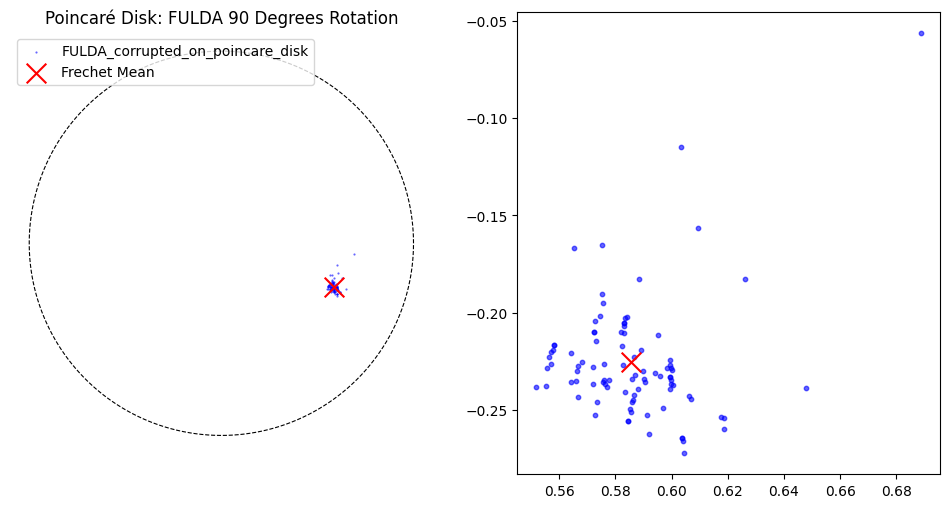

In [17]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
theta = np.linspace(0,2*np.pi,200)
ax[0].plot(np.cos(theta), np.sin(theta), 'k--', lw=0.8)
ax[0].scatter(points_to_disk_n[:,0], points_to_disk_n[:,1], c='blue', alpha=0.6, s=0.3, label='FULDA_corrupted_on_poincare_disk')
ax[0].scatter(fm_pd[0],fm_pd[1],marker='x',color='red',s=200,label='Frechet Mean')
ax[0].set_xlim([-1.1, 1.1])
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_aspect('equal')
ax[0].axis('off')
ax[0].legend(loc='upper left')
ax[0].set_title("Poincaré Disk: FULDA 90 Degrees Rotation")
ax[1].scatter(points_to_disk_n[:,0], points_to_disk_n[:,1], c='blue', alpha=0.6, s=10, label='Zooomed')
ax[1].scatter(fm_pd[0],fm_pd[1],marker='x',color='red',s=200,label='Frechet Mean')

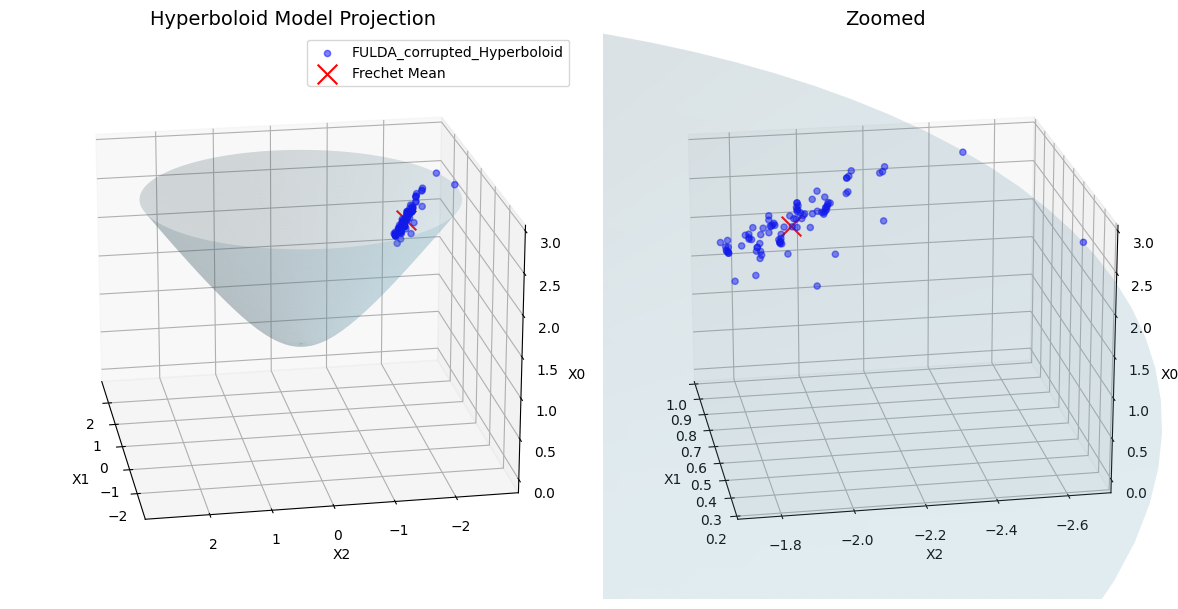

In [18]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(points_to_hbo[:, 1],  # X1
           points_to_hbo[:, 2],  # X2
           points_to_hbo[:, 0],  # X0
           color='blue', label='FULDA_corrupted_Hyperboloid', alpha=0.5)

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X0")
ax.set_zlim((-0.1,3))
ax.set_title("Hyperboloid Model Projection", fontsize=14)

# Plot the hyperboloid surface with projected data
# Hyperboloid surface mesh
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, 1.7, 100)  # avoid v=1 exactly to stay on upper sheet

U, V = np.meshgrid(u, v)
X1 = np.sinh(V) * np.cos(U)
X2 = np.sinh(V) * np.sin(U)
X0 = np.cosh(V)

# Surface
ax.plot_surface(
    X1, X2, X0,
    rstride=1, cstride=1,
    color='skyblue', alpha=0.2,
    edgecolor='none'
)
ax.scatter(fm_hbo[1],fm_hbo[2],fm_hbo[0],marker='x',color='red',s=200,label='Frechet Mean')
ax.legend()
ax.view_init(elev=20, azim=170)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points_to_hbo[:, 1],  # X1
           points_to_hbo[:, 2],  # X2
           points_to_hbo[:, 0],  # X0
           color='blue', label='FULDA_corrupted_Hyperboloid', alpha=0.5)
    
ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
ax2.set_zlabel("X0")
ax2.set_ylim((-2.7,-1.7))
ax2.set_xlim((0.2,1))
ax2.set_zlim((-0.1,3))
ax2.set_title("Zoomed", fontsize=14)

ax2.plot_surface(
    X1, X2, X0,
    rstride=1, cstride=1,
    color='skyblue', alpha=0.2,
    edgecolor='none'
)
ax2.scatter(fm_hbo[1],fm_hbo[2],fm_hbo[0],marker='x',color='red',s=200,label='Frechet Mean')
ax2.view_init(elev=20, azim=170)

plt.tight_layout()

#### Now, we utilize several robust M-estimators to see if this makes a subtle difference to hyperbolic mean estimates.
#### It's great to start with M-estimator with Huber loss, and I call the following estimated location parameter as Huber mean from now on.

## select a robust M-estimator 
* huber_loss
* pseudo_huber_loss
* fair_loss
* cauchy_loss
* biweight_loss
* welsch_loss
* hampel_loss
* correntropy_loss
* logistic_loss
* lorentzian_loss

[reference] [CCE2021] D.Q.F. de Menezes et al. A review on robust m-estimators for regression analysis. https://doi.org/10.1016/j.compchemeng.2021.107254

#### * The rho functions of some representative robust M-estimators above are predefined and provided in the code. You can compute location parameter based on the samples on the manifold by choosing the proper rho function style.

## 1. Huber Loss (Poincare Half-plane)
[reference] (2024) Jongmin Lee, Sungkyu Jung. Huber means on Riemannian manifolds, https://doi.org/10.48550/arXiv.2407.15764

In [19]:
# Autograd + huber
huber_auto = rrm.RiemannianRobustMean(phs, 1.3, m_estimator='huber', method='autograd',init_point_method='first')
huber_auto.set(max_iter=50000,init_step_size=0.5,init_point=points_90r[5],epsilon=1e-7)
huber_auto.fit(points_90r)
print('Huber mean: {} ( baseline Frechet mean: {})'.format(huber_auto.estimate_.x,fm.estimate_))
print('distance: {} '.format(phs.metric.dist(huber_auto.estimate_.x,fm.estimate_)))
huber_pd = transform_2d_poincare_half_plane_to_poincare_disk(huber_auto.estimate_.x)
huber_hbo = transform_2d_poincare_half_plane_to_hyperboloid(huber_auto.estimate_.x)

0th iteration processing...  [0.01 seconds]
base:[1.187, 5.102], gradient:[-0.116, 0.237], step size: 0.5, current loss: 0.4910752]
50th iteration processing...  [0.31 seconds]
base:[2.023, 2.734], gradient:[-0.001, 0.003], step size: 0.5, current loss: 0.0151875]
100th iteration processing...  [0.55 seconds]
base:[2.025, 2.724], gradient:[-0.0, 0.0], step size: 0.5, current loss: 0.0151695]
Huber mean: [2.02487151 2.72415404] ( baseline Frechet mean: [2.02573376 2.72479434])
distance: 0.0003942024574519985 


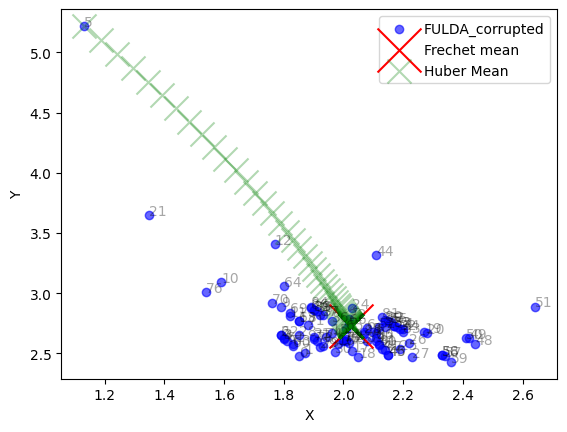

In [20]:
ax = visualization.plot(points_90r,space='H2_poincare_half_plane', c='blue', alpha=0.6, label='FULDA_corrupted')
for i in range(len(points_90r)):
    plt.text(points_90r[i,0],points_90r[i,1],i,alpha=0.35)

visualization.plot(fm.estimate_,space='H2_poincare_half_plane', c='red', marker='x', s=1000, label='Frechet mean',ax=ax)
# visualization.plot(huber_auto.estimate_.x,space='H2_poincare_half_plane', marker='x', s=500, c='green', label='Huber mean')

for i,c in enumerate(huber_auto.estimate_.bases):
    if i==0:
        ax.scatter(*c, marker="x", s=300, color='green',label='Huber Mean',alpha=0.3,)
    else:
        ax.scatter(*c, marker="x", s=300, color='green',alpha=0.3,)
# ax.scatter(*c, marker="x", s=300, color='green',alpha=0.3,)
        
plt.legend()

### Let's see the 2 means in other hyperbolic manifolds

### * Transforming manifold to H2 Poincare Disk

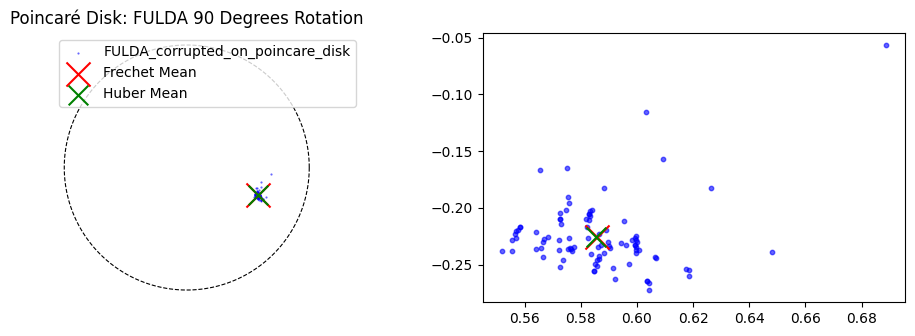

In [21]:
fig, ax = plt.subplots(1,2,figsize=(12,3.5))
theta = np.linspace(0,2*np.pi,200)
ax[0].plot(np.cos(theta), np.sin(theta), 'k--', lw=0.8)
ax[0].scatter(points_to_disk_n[:,0], points_to_disk_n[:,1], c='blue', alpha=0.6, s=0.3, label='FULDA_corrupted_on_poincare_disk')
ax[0].scatter(fm_pd[0],fm_pd[1],marker='x',color='red',s=300,label='Frechet Mean')
ax[0].scatter(huber_pd[0],huber_pd[1],marker='x',color='green',s=200,label='Huber Mean')
ax[0].set_xlim([-1.1, 1.1])
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_aspect('equal')
ax[0].axis('off')
ax[0].legend(loc='upper left')
ax[0].set_title("Poincaré Disk: FULDA 90 Degrees Rotation")
ax[1].scatter(points_to_disk_n[:,0], points_to_disk_n[:,1], c='blue', alpha=0.6, s=10, label='Zooomed')
ax[1].scatter(fm_pd[0],fm_pd[1],marker='x',color='red',s=300,label='Frechet Mean')
ax[1].scatter(huber_pd[0],huber_pd[1],marker='x',color='green',s=200,label='Huber Mean')

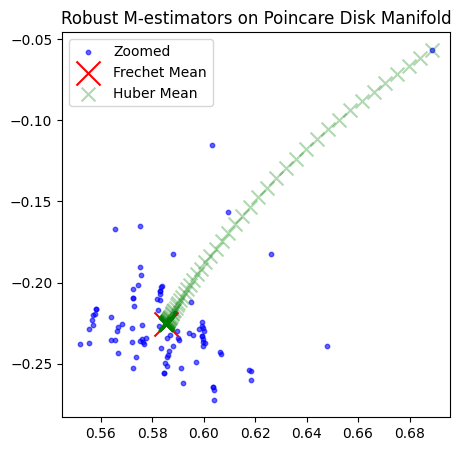

In [22]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(points_to_disk_n[:,0], points_to_disk_n[:,1], c='blue', alpha=0.6, s=10, label='Zoomed')
ax.scatter(fm_pd[0],fm_pd[1],marker='x',color='red',s=300,label='Frechet Mean')
#ax.scatter(huber_pd[0],huber_pd[1],marker='x',color='green',s=200,label='Huber Mean')

for i,c in enumerate(huber_auto.estimate_.bases):
    c_pb = transform_2d_poincare_half_plane_to_poincare_disk(c)
    if i==0:
        ax.scatter(*c_pb, marker="x", s=100, color='green',label='Huber Mean',alpha=0.3,)
    else:
        ax.scatter(*c_pb, marker="x", s=100, color='green',alpha=0.3,)

ax.set_title("Robust M-estimators on Poincare Disk Manifold")
ax.legend();

### * Transforming to Hyperboloid

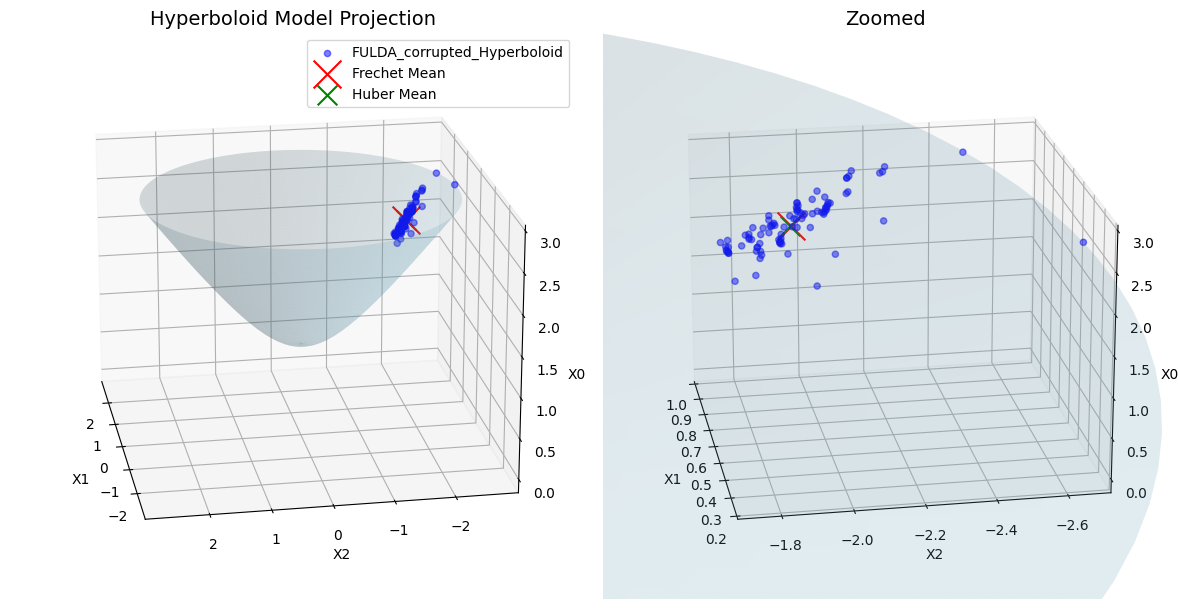

In [23]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(points_to_hbo[:, 1],  # X1
           points_to_hbo[:, 2],  # X2
           points_to_hbo[:, 0],  # X0
           color='blue', label='FULDA_corrupted_Hyperboloid', alpha=0.5)

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X0")
ax.set_zlim((-0.1,3))
ax.set_title("Hyperboloid Model Projection", fontsize=14)

# Plot the hyperboloid surface with projected data
# Hyperboloid surface mesh
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, 1.7, 100)  # avoid v=1 exactly to stay on upper sheet

U, V = np.meshgrid(u, v)
X1 = np.sinh(V) * np.cos(U)
X2 = np.sinh(V) * np.sin(U)
X0 = np.cosh(V)

# Surface
ax.plot_surface(
    X1, X2, X0,
    rstride=1, cstride=1,
    color='skyblue', alpha=0.2,
    edgecolor='none'
)
ax.scatter(fm_hbo[1],fm_hbo[2],fm_hbo[0],marker='x',color='red',s=400,label='Frechet Mean')
ax.scatter(huber_hbo[1],huber_hbo[2],huber_hbo[0],marker='x',color='green',s=200,label='Huber Mean')
ax.legend()
ax.view_init(elev=20, azim=170)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points_to_hbo[:, 1],  # X1
           points_to_hbo[:, 2],  # X2
           points_to_hbo[:, 0],  # X0
           color='blue', label='FULDA_corrupted_Hyperboloid', alpha=0.5)
    
ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
ax2.set_zlabel("X0")
ax2.set_ylim((-2.7,-1.7))
ax2.set_xlim((0.2,1))
ax2.set_zlim((-0.1,3))
ax2.set_title("Zoomed", fontsize=14)

ax2.plot_surface(
    X1, X2, X0,
    rstride=1, cstride=1,
    color='skyblue', alpha=0.2,
    edgecolor='none'
)
ax2.scatter(fm_hbo[1],fm_hbo[2],fm_hbo[0],marker='x',color='red',s=400,label='Frechet Mean')
ax2.scatter(huber_hbo[1],huber_hbo[2],huber_hbo[0],marker='x',color='green',s=200,label='Huber Mean')
ax2.view_init(elev=20, azim=170)

plt.tight_layout()

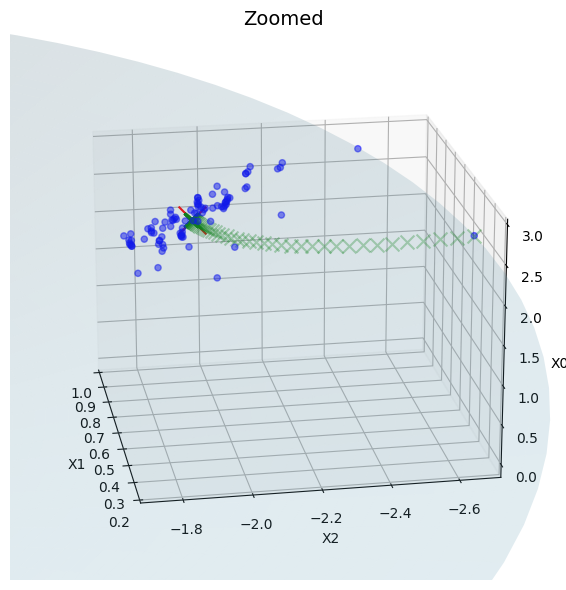

In [24]:
fig = plt.figure(figsize=(6, 6))
ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(points_to_hbo[:, 1],  # X1
           points_to_hbo[:, 2],  # X2
           points_to_hbo[:, 0],  # X0
           color='blue', label='FULDA_corrupted_Hyperboloid', alpha=0.5)
    
ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
ax2.set_zlabel("X0")
ax2.set_ylim((-2.7,-1.7))
ax2.set_xlim((0.2,1))
ax2.set_zlim((-0.1,3))
ax2.set_title("Zoomed", fontsize=14)

ax2.plot_surface(
    X1, X2, X0,
    rstride=1, cstride=1,
    color='skyblue', alpha=0.2,
    edgecolor='none'
)
ax2.scatter(fm_hbo[1],fm_hbo[2],fm_hbo[0],marker='x',color='red',s=400,label='Frechet Mean')
# ax2.scatter(huber_hbo[1],huber_hbo[2],huber_hbo[0],marker='x',color='green',s=200,label='Huber Mean')
for i,c in enumerate(huber_auto.estimate_.bases):
    c_hbo = transform_2d_poincare_half_plane_to_hyperboloid(c)
    if i==0:
        ax2.scatter(c_hbo[1],c_hbo[2],c_hbo[0], marker="x", s=100, color='green',label='Huber Mean',alpha=0.3,)
    else:
        ax2.scatter(c_hbo[1],c_hbo[2],c_hbo[0], marker="x", s=100, color='green',alpha=0.3,)


ax2.view_init(elev=20, azim=170)

plt.tight_layout()

## 1-1. Huber mean optimized on Poincare Disk

We can select among 3 manifolds for hyperbolic data, which are Poincare half plane, Poincare Disk, Hyperboloid. Since the 3 manifolds are isometry, we can choose proper one which has the best optimization property based on the data we have.

Thus, the process below compares the optimization status on Poincare half plane manifold where the data we have are to that on other manifolds.

In [14]:
# Autograd + huber
fm_o_pd = FrechetMean(pb)
fm_o_pd.set(max_iter=512,init_point=points_to_disk_n[5])
fm_o_pd.fit(points_to_disk_n)

huber_auto = rrm.RiemannianRobustMestimator(pb, 1.3, m_estimator='huber', method='autograd',init_point_method='mean-projection')
huber_auto.set(max_iter=2048,init_step_size=0.02,init_point=points_to_disk_n[5],verbose=True)  #
huber_auto.fit(points_to_disk_n)
print('Huber mean: {} ( baseline Frechet mean: {})'.format(huber_auto.estimate_.x,fm_o_pd.estimate_))
print('distance: {} '.format(pb.metric.dist(huber_auto.estimate_.x,fm_o_pd.estimate_)))
# huber_pd = transform_2d_poincare_half_plane_to_poincare_disk(huber_auto.estimate_.x)
# huber_hbo = transform_2d_poincare_half_plane_to_hyperboloid(huber_auto.estimate_.x)

INFO: Tolerance threshold reached at iter 79
INFO: Number of gradient evaluations: 84, Number of gradient iterations: 79,  loss at termination: 1.517000e-02,  standard deviation at termination: 1.231650e-01, 


50th iteration processing...  [0.17 seconds]
base:[0.586, -0.225],                     gradient:[0.0, 0.0],                     step size: 0.02, current loss: 0.0151695]
Huber mean: [ 0.58550107 -0.22536859] ( baseline Frechet mean: [ 0.58528822 -0.22558884])
distance: 0.0010100918611053635 


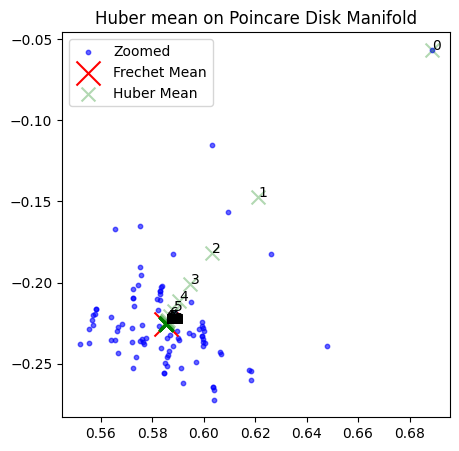

In [15]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(points_to_disk_n[:,0], points_to_disk_n[:,1], c='blue', alpha=0.6, s=10, label='Zoomed')
ax.scatter(fm_o_pd.estimate_[0],fm_o_pd.estimate_[1],marker='x',color='red',s=300,label='Frechet Mean')
#ax.scatter(huber_pd[0],huber_pd[1],marker='x',color='green',s=200,label='Huber Mean')

for i,c in enumerate(huber_auto.estimate_.bases):
    if i==0:
        ax.scatter(*c, marker="x", s=100, color='green',label='Huber Mean',alpha=0.3,)
        ax.text(*c,s=i)
    else:
        ax.scatter(*c, marker="x", s=100, color='green',alpha=0.3,)
        ax.text(*c,s=i)

ax.set_title("Huber mean on Poincare Disk Manifold")
ax.legend();

### Iterative process of optimization shows that the intermediate optimization steps are quite different on Poincare Disk from on Poincare Half Plane, but the optimization result is almost the same.

### Let's move on to Hyperboloid.

## 1-2. Huber mean optimized on Hyperboloid

In [26]:
# Autograd + huber
fm_o_hbo = FrechetMean(hbo)
fm_o_hbo.set(max_iter=512,init_point=points_to_hbo[5])
fm_o_hbo.fit(points_to_hbo)

huber_auto = rrm.RiemannianRobustMean(hbo, 1.3, m_estimator='huber', method='default',init_point_method='mean-projection')
huber_auto.set(max_iter=512, init_step_size=0.03, init_point=points_to_hbo[5])  # ,epsilon=1e-15
huber_auto.fit(points_to_hbo)
print('Huber mean: {} ( baseline Frechet mean: {})'.format(huber_auto.estimate_.x,fm_o_hbo.estimate_))
print('distance: {} '.format(hbo.metric.dist(huber_auto.estimate_.x,fm_o_hbo.estimate_)))
# huber_pd = transform_2d_poincare_half_plane_to_poincare_disk(huber_auto.estimate_.x)
# huber_hbo = transform_2d_poincare_half_plane_to_hyperboloid(huber_auto.estimate_.x)

0th iteration processing...  [0.00 seconds] 
base:[2.828, 0.216, -2.637], gradient:[-2.278, 0.876, 2.516], step size: 0.03000, current loss(grad norm): 1.38061(loss:0.49108)]
50th iteration processing...  [0.03 seconds] 
base:[2.298, 0.714, -1.941], gradient:[-0.001, 0.058, 0.023], step size: 0.03000, current loss(grad norm): 0.06231(loss:0.01614)]
100th iteration processing...  [0.06 seconds] 
base:[2.298, 0.742, -1.932], gradient:[0.0, 0.003, 0.001], step size: 0.03000, current loss(grad norm): 0.00281(loss:0.01517)]
150th iteration processing...  [0.09 seconds] 
base:[2.298, 0.743, -1.931], gradient:[0.0, 0.0, 0.0], step size: 0.03000, current loss(grad norm): 0.00013(loss:0.01517)]
200th iteration processing...  [0.12 seconds] 
base:[2.298, 0.743, -1.931], gradient:[0.0, 0.0, 0.0], step size: 0.03000, current loss(grad norm): 0.00001(loss:0.01517)]
Huber mean: [ 2.29816659  0.74330224 -1.93108039] ( baseline Frechet mean: [ 2.29735168  0.74384574 -1.9299011 ])
distance: 0.001010955

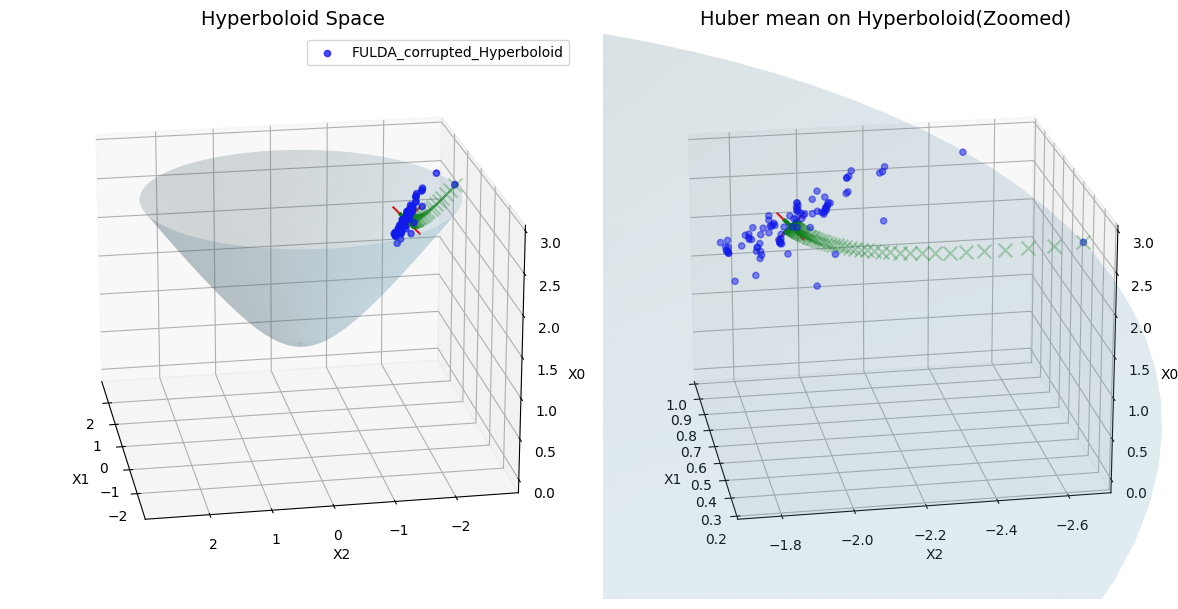

In [27]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(points_to_hbo[:, 1],  # X1
           points_to_hbo[:, 2],  # X2
           points_to_hbo[:, 0],  # X0
           color='blue', label='FULDA_corrupted_Hyperboloid', alpha=0.7)

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X0")
ax.set_zlim((-0.1,3))
ax.set_title("Hyperboloid Space", fontsize=14)
ax.legend()

# Plot the hyperboloid surface with projected data
# Hyperboloid surface mesh
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, 1.7, 100)  # avoid v=1 exactly to stay on upper sheet

U, V = np.meshgrid(u, v)
X1 = np.sinh(V) * np.cos(U)
X2 = np.sinh(V) * np.sin(U)
X0 = np.cosh(V)

# Surface
ax.plot_surface(
    X1, X2, X0,
    rstride=1, cstride=1,
    color='skyblue', alpha=0.2,
    edgecolor='none'
)

ax.scatter(fm_o_hbo.estimate_[1],fm_o_hbo.estimate_[2],fm_o_hbo.estimate_[0],marker='x',color='red',s=400,label='Frechet Mean')
for i,c in enumerate(huber_auto.estimate_.bases):
    if i==0:
        ax.scatter(c[1],c[2],c[0], marker="x", s=100, color='green',label='Huber Mean',alpha=0.3,)
    else:
        ax.scatter(c[1],c[2],c[0], marker="x", s=100, color='green',alpha=0.3,)
        
ax.view_init(elev=20, azim=170)


ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points_to_hbo[:, 1],  # X1
           points_to_hbo[:, 2],  # X2
           points_to_hbo[:, 0],  # X0
           color='blue', label='FULDA_corrupted_Hyperboloid', alpha=0.5)
    
ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
ax2.set_zlabel("X0")
ax2.set_ylim((-2.7,-1.7))
ax2.set_xlim((0.2,1))
ax2.set_zlim((-0.1,3))
ax2.set_title("Huber mean on Hyperboloid(Zoomed)", fontsize=14)

ax2.plot_surface(
    X1, X2, X0,
    rstride=1, cstride=1,
    color='skyblue', alpha=0.2,
    edgecolor='none'
)
ax2.scatter(fm_o_hbo.estimate_[1],fm_o_hbo.estimate_[2],fm_o_hbo.estimate_[0],marker='x',color='red',s=400,label='Frechet Mean')
for i,c in enumerate(huber_auto.estimate_.bases):
    if i==0:
        ax2.scatter(c[1],c[2],c[0], marker="x", s=100, color='green',label='Huber Mean',alpha=0.3,)
    else:
        ax2.scatter(c[1],c[2],c[0], marker="x", s=100, color='green',alpha=0.3,)


ax2.view_init(elev=20, azim=170)

plt.tight_layout()

## 2. fair loss

In [28]:
# Autograd + fair
fair_auto = rrm.RiemannianRobustMean(hbo, 3, m_estimator='fair', method='autograd')
fair_auto.set(max_iter=512)
fair_auto.fit(points_to_hbo)
print(fair_auto.estimate_.x)

D:\NNs_v2\NN_model\lib\site-packages\autograd\numpy\numpy_vjps.py:91: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.arccosh, lambda ans, x : lambda g: g / anp.sqrt(x**2 - 1))
D:\NNs_v2\NN_model\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


0th iteration processing...  [0.02 seconds]
base:[2.132, 0.746, -1.728], gradient:[2.132, 0.746, -1.728], step size: 0.05, current loss: 0.0133338]
50th iteration processing...  [0.13 seconds]
base:[2.298, 0.745, -1.93], gradient:[0.0, 0.001, 0.0], step size: 0.1, current loss: 0.0070669]
100th iteration processing...  [0.23 seconds]
base:[2.298, 0.745, -1.93], gradient:[0.0, 0.0, 0.0], step size: 0.1, current loss: 0.0070668]
[ 2.29808424  0.74492609 -1.93035652]


## 3. Hampel loss

In [29]:
# Autograd + Hampel
Hampel_auto = rrm.RiemannianRobustMean(hbo, 2, m_estimator='Hampel', method='autograd')
Hampel_auto.set(max_iter=512)
Hampel_auto.fit(points_to_hbo)
print(Hampel_auto.estimate_.x)

0th iteration processing...  [0.00 seconds]
base:[2.132, 0.746, -1.728], gradient:[2.132, 0.746, -1.728], step size: 0.05, current loss: 0.0142743]
50th iteration processing...  [0.11 seconds]
base:[2.298, 0.744, -1.931], gradient:[0.0, 0.0, 0.0], step size: 0.1, current loss: 0.0075849]
100th iteration processing...  [0.22 seconds]
base:[2.298, 0.743, -1.931], gradient:[0.0, 0.0, 0.0], step size: 0.1, current loss: 0.0075848]
[ 2.29816666  0.74330406 -1.93107977]


## 4. Tukey's biweight loss

In [30]:
# Autograd + biweight
biweight_auto = rrm.RiemannianRobustMean(hbo, 4.7, m_estimator='biweight', method='autograd')
biweight_auto.set(max_iter=512)
biweight_auto.fit(points_to_hbo)
print(biweight_auto.estimate_.x)

0th iteration processing...  [0.00 seconds]
base:[2.132, 0.746, -1.728], gradient:[2.132, 0.746, -1.728], step size: 0.05, current loss: 0.0141633]
50th iteration processing...  [0.10 seconds]
base:[2.298, 0.744, -1.931], gradient:[0.0, 0.0, 0.0], step size: 0.1, current loss: 0.0075211]
100th iteration processing...  [0.20 seconds]
base:[2.298, 0.744, -1.931], gradient:[0.0, 0.0, 0.0], step size: 0.1, current loss: 0.007521]
[ 2.29818091  0.74366029 -1.93095958]


## 5. correntropy loss

In [31]:
# Autograd + correntropy
correntropy_auto = rrm.RiemannianRobustMean(hbo, 2.12, m_estimator='correntropy', method='autograd')
correntropy_auto.set(max_iter=512)
correntropy_auto.fit(points_to_hbo)
print(correntropy_auto.estimate_.x)

0th iteration processing...  [0.00 seconds]
base:[2.132, 0.746, -1.728], gradient:[2.132, 0.746, -1.728], step size: 0.05, current loss: 0.000592]
50th iteration processing...  [0.10 seconds]
base:[2.267, 0.792, -1.874], gradient:[-0.011, -0.002, 0.012], step size: 0.1, current loss: 0.0004101]
100th iteration processing...  [0.22 seconds]
base:[2.291, 0.79, -1.903], gradient:[-0.002, 0.001, 0.003], step size: 0.1, current loss: 0.0003748]
150th iteration processing...  [0.31 seconds]
base:[2.295, 0.783, -1.912], gradient:[-0.0, 0.002, 0.001], step size: 0.1, current loss: 0.0003541]
200th iteration processing...  [0.41 seconds]
base:[2.296, 0.776, -1.916], gradient:[-0.0, 0.001, 0.001], step size: 0.1, current loss: 0.0003405]
250th iteration processing...  [0.50 seconds]
base:[2.297, 0.77, -1.919], gradient:[-0.0, 0.001, 0.001], step size: 0.1, current loss: 0.0003315]
300th iteration processing...  [0.59 seconds]
base:[2.297, 0.765, -1.922], gradient:[-0.0, 0.001, 0.0], step size: 0

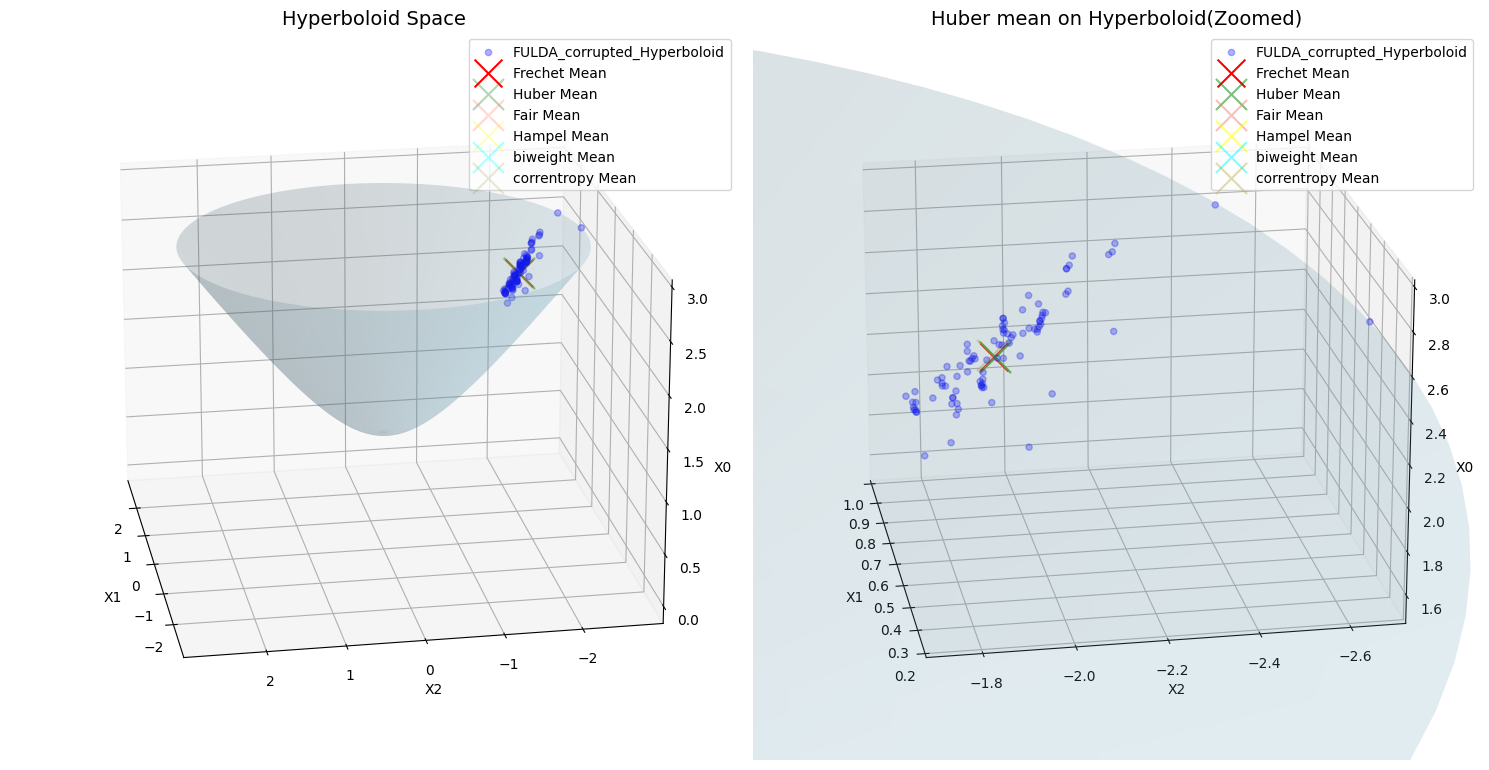

In [32]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(points_to_hbo[:, 1],  # X1
           points_to_hbo[:, 2],  # X2
           points_to_hbo[:, 0],  # X0
           color='blue', label='FULDA_corrupted_Hyperboloid', alpha=0.3)

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X0")
ax.set_zlim((-0.1,3))
ax.set_title("Hyperboloid Space", fontsize=14)


# Plot the hyperboloid surface with projected data
# Hyperboloid surface mesh
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, 1.7, 100)  # avoid v=1 exactly to stay on upper sheet

U, V = np.meshgrid(u, v)
X1 = np.sinh(V) * np.cos(U)
X2 = np.sinh(V) * np.sin(U)
X0 = np.cosh(V)

# Surface
ax.plot_surface(
    X1, X2, X0,
    rstride=1, cstride=1,
    color='skyblue', alpha=0.2,
    edgecolor='none'
)

ax.scatter(fm_o_hbo.estimate_[1],fm_o_hbo.estimate_[2],fm_o_hbo.estimate_[0],marker='x',color='red',s=400,label='Frechet Mean')
ax.scatter(huber_auto.estimate_.x[1],huber_auto.estimate_.x[2],huber_auto.estimate_.x[0],
           marker="x", alpha=0.3, s=500, color='green',label='Huber Mean')
ax.scatter(fair_auto.estimate_.x[1], fair_auto.estimate_.x[2], fair_auto.estimate_.x[0],
           marker="x", alpha=0.3, s=500, color='#FA8072',label='Fair Mean')
ax.scatter(Hampel_auto.estimate_.x[1], Hampel_auto.estimate_.x[2], Hampel_auto.estimate_.x[0],
           marker="x", alpha=0.3, s=500, color='yellow',label='Hampel Mean')
ax.scatter(biweight_auto.estimate_.x[1], biweight_auto.estimate_.x[2], biweight_auto.estimate_.x[0],
           marker="x", alpha=0.3, s=500, color='cyan',label='biweight Mean')
ax.scatter(correntropy_auto.estimate_.x[1], correntropy_auto.estimate_.x[2], correntropy_auto.estimate_.x[0],
           marker="x", alpha=0.3, s=500, color='#BDB76B',label='correntropy Mean')
ax.legend()       
ax.view_init(elev=20, azim=170)


ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points_to_hbo[:, 1],  # X1
           points_to_hbo[:, 2],  # X2
           points_to_hbo[:, 0],  # X0
           color='blue', label='FULDA_corrupted_Hyperboloid', alpha=0.3)
    
ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
ax2.set_zlabel("X0")
ax2.set_ylim((-2.7,-1.7))
ax2.set_xlim((0.2,1))
ax2.set_zlim((1.5,3))
ax2.set_title("Huber mean on Hyperboloid(Zoomed)", fontsize=14)

ax2.plot_surface(
    X1, X2, X0,
    rstride=1, cstride=1,
    color='skyblue', alpha=0.2,
    edgecolor='none'
)
ax2.scatter(fm_o_hbo.estimate_[1],fm_o_hbo.estimate_[2],fm_o_hbo.estimate_[0],marker='x',color='red',s=400,label='Frechet Mean')
ax2.scatter(huber_auto.estimate_.x[1],huber_auto.estimate_.x[2],huber_auto.estimate_.x[0],
           marker="x", alpha=0.5, s=500, color='green',label='Huber Mean')
ax2.scatter(fair_auto.estimate_.x[1], fair_auto.estimate_.x[2], fair_auto.estimate_.x[0],
           marker="x", alpha=0.5, s=500, color='#FA8072',label='Fair Mean')
ax2.scatter(Hampel_auto.estimate_.x[1], Hampel_auto.estimate_.x[2], Hampel_auto.estimate_.x[0],
           marker="x", alpha=0.5, s=500, color='yellow',label='Hampel Mean')
ax2.scatter(biweight_auto.estimate_.x[1], biweight_auto.estimate_.x[2], biweight_auto.estimate_.x[0],
           marker="x", alpha=0.5, s=500, color='cyan',label='biweight Mean')
ax2.scatter(correntropy_auto.estimate_.x[1], correntropy_auto.estimate_.x[2], correntropy_auto.estimate_.x[0],
           marker="x", alpha=0.5, s=500, color='#BDB76B',label='correntropy Mean')

ax2.view_init(elev=20, azim=170)
ax2.legend()
plt.tight_layout()

### In "autograd/pytorch" backend setting, you can give customized rho function of M-estimator by which you can compute location parameter. 
### Because we now deal with the data on the Riemannian manifold, the customized rho function must have the 3 inputs, "space(manifold), points(samples), base(base point needed for tangent space)".
### In order for a rho function have robustness property, this type of customized rho function should have critical value, which plays a role of threshold that diminishs the effect of outliers, needed to be set as input "critical_value".

## Custom Loss Template(Required):

In [ ]:
def custom_loss(space, points, base, critical_value=None, weights=None):
    # returns loss (scalar) OR loss, gradient

- **Required arguments**: `space`, `points`, `base`
- **Optional**: `critical_value`, `weights`
- If `weights` is used, must satisfy `len(weights) == len(points)`

### Example:

In [ ]:
def basic1_loss(space,points,base,weights=None):
    n = len(points)
    if weights is None:
        weights = gs.ones(n)
    distances = space.metric.squared_dist(points, base)
    return gs.sum(weights * distances) / gs.sum(weights)

robust_mean = rrm.RiemannianRobustMean(space, c_value, method='autograd')
robust_mean._set_loss(fun=basic1_loss)
robust_mean.fit(points)